# **Training a Classification Model:**
## **Predicting Customer Response to a Marketing Campaign**

In [2]:
#libraries import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

#
import shap

#
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay

First, we load the datasets. According to the results of EDA, `cleaned_df` contains samples cleared of anomalies according to the rule `drop all samples where the experience exceeds the age of a person - 16 years.`

In [3]:
df = pd.read_csv('./datasets/general_df.csv', index_col=0)
cleaned_df = pd.read_csv('./datasets/general_df_cleaned.csv', index_col=0)

display(df.head())
print('Number of samples in the original data:', len(df))
display(cleaned_df.head())
print('Number of samples in the cleaned data:', len(cleaned_df))

,target,credit,term,fst_payment,age,gender,education,marital_status,child_total,dependants,...,own_auto,family_income,personal_income,gen_industry,gen_title,job_dir,work_time,closed_loans_count,total_loans_count,work_time_in_years
0,0,8000.00,6,8650.0,49,1,среднее специальное,состою в браке,2,1,...,0,от 10000 до 20000 руб.,5000.0,торговля,рабочий,вспомогательный техперсонал,18.0,1,1,1.0
2,0,21650.00,6,4000.0,32,1,среднее,состою в браке,3,3,...,0,от 10000 до 20000 руб.,12000.0,торговля,рабочий,участие в основ. деятельности,97.0,1,1,8.0
3,0,33126.00,12,4000.0,52,1,неполное среднее,состою в браке,4,0,...,0,от 10000 до 20000 руб.,9000.0,информационные технологии,специалист,участие в основ. деятельности,84.0,1,2,7.0
4,0,8491.82,6,5000.0,39,1,высшее,состою в браке,1,1,...,0,от 20000 до 50000 руб.,25000.0,образование,руководитель среднего звена,участие в основ. деятельности,168.0,1,1,14.0
5,0,21990.00,12,4000.0,30,0,среднее,состою в браке,0,0,...,0,от 10000 до 20000 руб.,12000.0,государственная служба,специалист,участие в основ. деятельности,101.0,1,2,8.0


Number of samples in the original data: 15223


,target,credit,term,fst_payment,age,gender,education,marital_status,child_total,dependants,...,own_auto,family_income,personal_income,gen_industry,gen_title,job_dir,work_time,closed_loans_count,total_loans_count,work_time_in_years
0,0,8000.00,6,8650.0,49,1,Среднее специальное,Состою в браке,2,1,...,0,от 10000 до 20000 руб.,5000.0,Торговля,Рабочий,Вспомогательный техперсонал,18.0,1,1,1.0
2,0,21650.00,6,4000.0,32,1,Среднее,Состою в браке,3,3,...,0,от 10000 до 20000 руб.,12000.0,Торговля,Рабочий,Участие в основ. деятельности,97.0,1,1,8.0
3,0,33126.00,12,4000.0,52,1,Неполное среднее,Состою в браке,4,0,...,0,от 10000 до 20000 руб.,9000.0,Информационные технологии,Специалист,Участие в основ. деятельности,84.0,1,2,7.0
4,0,8491.82,6,5000.0,39,1,Высшее,Состою в браке,1,1,...,0,от 20000 до 50000 руб.,25000.0,Образование,Руководитель среднего звена,Участие в основ. деятельности,168.0,1,1,14.0
5,0,21990.00,12,4000.0,30,0,Среднее,Состою в браке,0,0,...,0,от 10000 до 20000 руб.,12000.0,Государственная служба,Специалист,Участие в основ. деятельности,101.0,1,2,8.0


Number of samples in the cleaned data: 15179


Based on the data analysis, a large number of categories by region and working data were also found (features `'reg_address_province', 'fact_address_province', 'postal_address_province', 'gen_industry', 'gen_title', 'job_dir')`. These features will be excluded to create a more interpretable model.

In [4]:
continuous_features = ['credit', 'fst_payment', 'age', 'child_total', 'dependants', 
                       'own_auto', 'personal_income', 'work_time', 'work_time_in_years', 'closed_loans_count', 'total_loans_count']

categorical_features = set([i for i in df.columns if i not in continuous_features])

features_to_remove = set(['reg_address_province', 'fact_address_province', 'postal_address_province', 'gen_industry', 'gen_title', 'job_dir'])

In [5]:
categorical_features -= features_to_remove

In [6]:
df.drop(features_to_remove, axis=1, inplace=True)
cleaned_df.drop(features_to_remove, axis=1, inplace=True)

Also, a different number of observations were found in the categories of the features `education`, `term`, `marital_status`, `Family income`. \
So the next step of the work is the preprocessing all the features.

Education.

In [7]:
print('Basic data')
display(df['education'].value_counts())
print('\nCleaned data')
display(cleaned_df['education'].value_counts())

Basic data


education
среднее специальное               6518
среднее                           4679
высшее                            3133
неоконченное высшее                532
неполное среднее                   340
два и более высших образования      20
ученая степень                       1
Name: count, dtype: int64


Cleaned data


education
Среднее специальное               6500
Среднее                           4663
Высшее                            3123
Неоконченное высшее                532
Неполное среднее                   340
Два и более высших образования      20
Ученая степень                       1
Name: count, dtype: int64

For this feature, we will choose the encoding by the OHE method. In addition, we will delete the column responsible for the categories `Неоконченное высшее`, `Неполное среднее`, `Два и более высших образования`, `Ученая степень` because there are less samples in these categories than 5% of the original dataset.

In [8]:
def get_OHE(data, feature, categories_to_remove):

    new_features = pd.get_dummies(data[feature])
    data[new_features.columns] = pd.get_dummies(data[feature])
    data = data.drop(categories_to_remove, axis=1)
    data = data.drop(feature, axis=1)
    
    return data

In [9]:
#Original data
df_encoded = get_OHE(df, 'education', ['неоконченное высшее', 'неполное среднее', 'два и более высших образования', 'ученая степень'])

#Cleaned data
df_cleaned_encoded = get_OHE(cleaned_df, 'education', ['Неоконченное высшее', 'Неполное среднее', 'Два и более высших образования', 'Ученая степень'])

Term.

In [10]:
print('Basic data')
display(df['term'].value_counts())
print('\nCleaned data')
display(cleaned_df['term'].value_counts())

Basic data


term
6     5063
12    2951
10    2473
3     1919
5      626
9      542
4      446
8      401
18     263
24     166
7      143
11      63
36      50
15      49
14      20
13      17
16      15
20       6
23       4
22       3
30       2
19       1
Name: count, dtype: int64


Cleaned data


term
6     5048
12    2947
10    2467
3     1912
5      621
9      540
4      444
8      401
18     263
24     165
7      142
11      63
36      49
15      49
14      20
13      17
16      15
20       6
23       4
22       3
30       2
19       1
Name: count, dtype: int64

Text(0.5, 1.0, 'Number of loans for different terms')

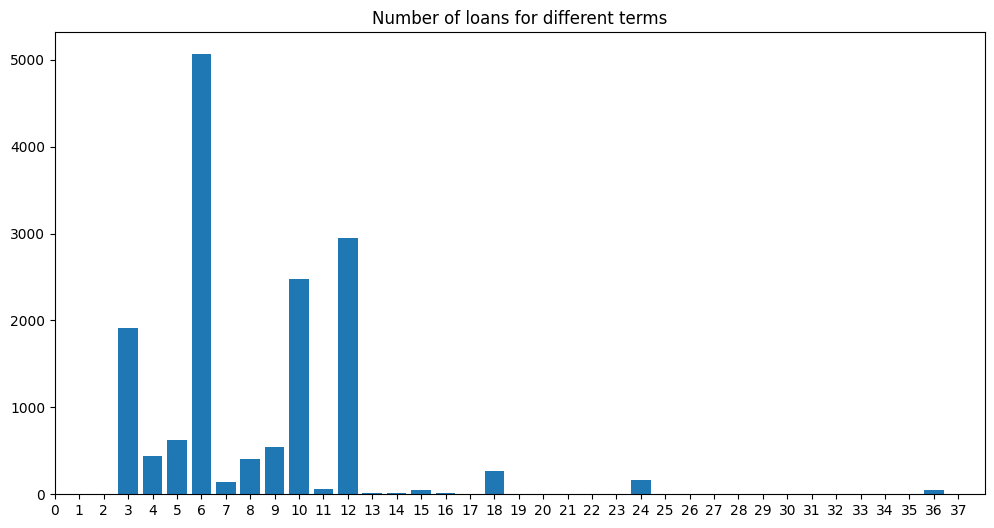

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

bar = plt.bar(x=df['term'].value_counts().index, height=list(df['term'].value_counts()))
plt.xticks(range(0, 38));
plt.title('Number of loans for different terms')

This feature will be divided into categories with the preservation of the most popular. 
- More than 12 months
- 11-12 months
- 7-10 months
- 4-6 months
- 1-3 months

In [12]:
def split_term_feature(x):
    if x > 0 and x <= 3:
        return 0
    elif x > 3 and x <= 6:
        return 1
    elif x > 6 and x <= 10:
        return 2
    elif x > 10 and x <= 12:
        return 3
    elif x > 12:
        return 4
    else:
        return None

In [13]:
df['term'] = df['term'].apply(lambda x: split_term_feature(x))
cleaned_df['term'] = cleaned_df['term'].apply(lambda x: split_term_feature(x))

Martial status.

In [14]:
print('Basic data')
display(df['marital_status'].value_counts())
print('\nCleaned data')
display(cleaned_df['marital_status'].value_counts())

Basic data


marital_status
состою в браке        9416
не состоял в браке    3622
разведен(а)           1245
вдовец/вдова           588
гражданский брак       352
Name: count, dtype: int64


Cleaned data


marital_status
Состою в браке        9383
Не состоял в браке    3617
Разведен(а)           1241
Вдовец/Вдова           586
Гражданский брак       352
Name: count, dtype: int64

This category will simply be encoded by the OHE method and we will delete `Гражданский брак`, `Вдовец/Вдова`.

In [15]:
#Original data
df_encoded = get_OHE(df_encoded, 'marital_status', ['вдовец/вдова', 'гражданский брак'])

#Cleaned data
df_cleaned_encoded = get_OHE(df_cleaned_encoded, 'marital_status', ['Вдовец/Вдова', 'Гражданский брак'])

Family income.

In [16]:
print('Basic data')
display(df['family_income'].value_counts())
print('\nCleaned data')
display(cleaned_df['family_income'].value_counts())

Basic data


family_income
от 10000 до 20000 руб.    7077
от 20000 до 50000 руб.    6082
от 5000 до 10000 руб.     1512
свыше 50000 руб.           492
до 5000 руб.                60
Name: count, dtype: int64


Cleaned data


family_income
от 10000 до 20000 руб.    7058
от 20000 до 50000 руб.    6061
от 5000 до 10000 руб.     1510
свыше 50000 руб.           490
до 5000 руб.                60
Name: count, dtype: int64

In [17]:
#Original data
df_encoded = get_OHE(df_encoded, 'family_income', ['свыше 50000 руб.', 'до 5000 руб.'])

#Cleaned data
df_cleaned_encoded = get_OHE(df_cleaned_encoded, 'family_income', ['свыше 50000 руб.', 'до 5000 руб.'])

Let's look at the correlations and remove the correlated features.

In [18]:
continuous_features.remove('work_time')

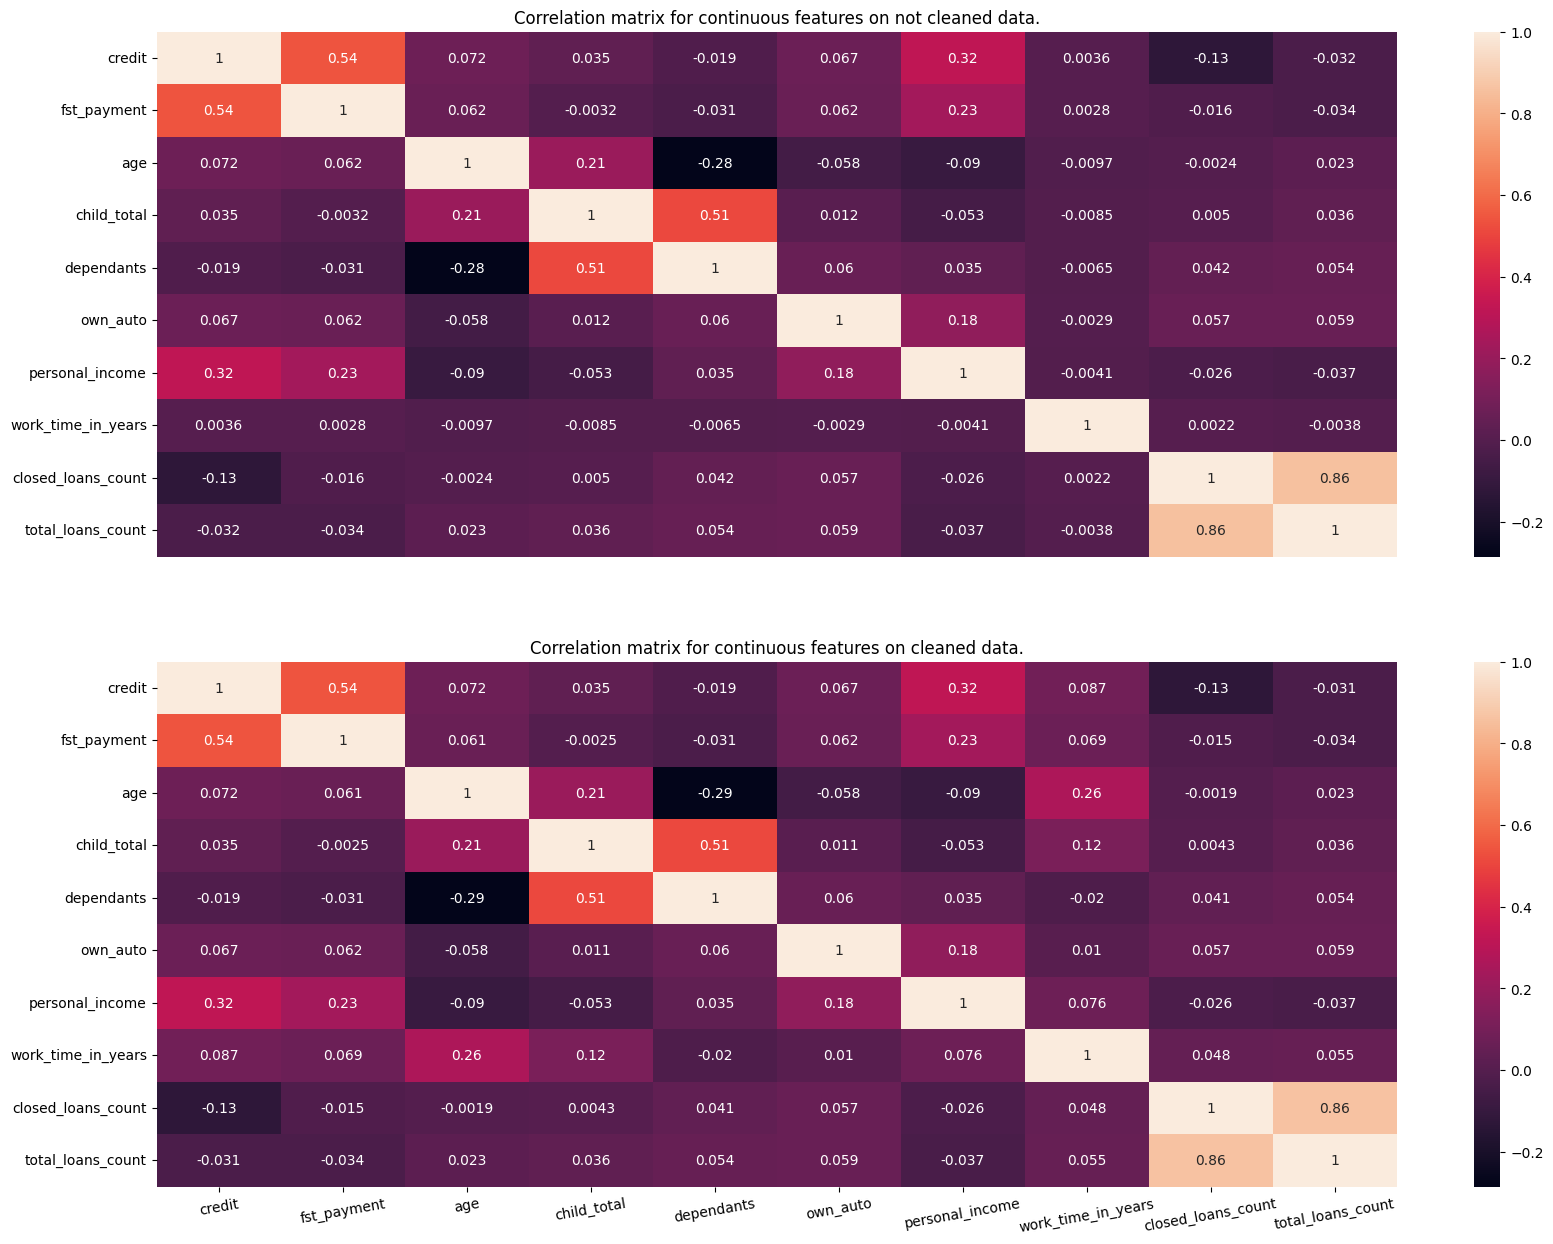

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(20, 15))

sns.heatmap(df_encoded[continuous_features].corr(), annot=True, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_title('Correlation matrix for continuous features on not cleaned data.')

sns.heatmap(df_cleaned_encoded[continuous_features].corr(), annot=True, ax=axes[1])
axes[1].set_title('Correlation matrix for continuous features on cleaned data.')

plt.xticks(rotation=10);

From the original data we will remove features `fst_payment`, `dependants`, `closed_loans_count`.
From the original data we will remove these features too. 

In [20]:
df_encoded.drop(['work_time', 'closed_loans_count'], axis=1, inplace=True)
df_cleaned_encoded.drop(['work_time', 'closed_loans_count'], axis=1, inplace=True)

Testing models.

In [108]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score

def get_results(model, X_train, X_test, y_train, y_test, title):
    
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    f1_sc = []
    precision_sc = []
    recall_sc = []
    probas = []
    
    for i in range(1, 100, 1):
        
        f1 = f1_score(y_test, model.predict_proba(X_test)[:, 1] > i/100, average='weighted', zero_division=0)
       
        recall = recall_score(y_test, model.predict_proba(X_test)[:, 1] > i/100, average='weighted', zero_division=0)
        precision = precision_score(y_test, model.predict_proba(X_test)[:, 1] > i/100, average='weighted', zero_division=0)
       
        f1_sc.append(f1)
        recall_sc.append(recall)
        precision_sc.append(precision)
        
        probas.append(i/100)

    max_x = probas[np.argmax(f1_sc)]
    max_y = max(f1_sc)

    plt.scatter(max_x, max_y, label=f'Max f1 score: {round(max_y, 3)} with proba {max_x}', c='orange')
    plt.plot(probas, f1_sc, label='f1 score')
    plt.plot(probas, recall_sc, label='recall score')
    plt.plot(probas, precision_sc, label='precision score')
    plt.legend()
    
    plt.xlabel('probability')
    plt.ylabel('f1, recall & precision scores')

    plt.title('Weighted classification scores')
    

    print(title+'\n')
    print(classification_report(y_test, predictions))
    print('Cross-val scores (f1):')
    print(cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted'))
    print('Test f1 score', f1_score(y_test, predictions, average='weighted')) 
    print('Test ROC-auc:', roc_auc_score(y_test, predictions)) 
    

    return model

In [109]:
#df_encoded.to_csv('./datasets/encoded_data.csv', index=False)

Logistic Regression on all data

              precision    recall  f1-score   support

           0       0.93      0.59      0.72      3072
           1       0.19      0.68      0.30       430

    accuracy                           0.60      3502
   macro avg       0.56      0.64      0.51      3502
weighted avg       0.84      0.60      0.67      3502

Cross-val scores (f1):
[0.6730464  0.65918849 0.66854559]
Test f1 score 0.6718592216400423
Test ROC-auc: 0.6352470930232559


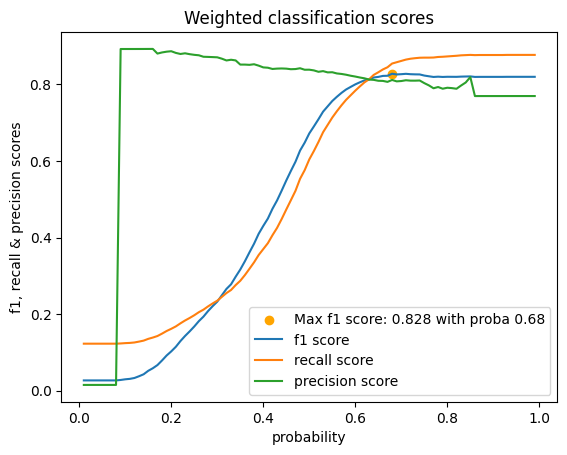

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_encoded.drop(['target'], axis=1)
y = df_encoded['target']

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.23, random_state=42)

sc = StandardScaler()
X_train_all_transformed = sc.fit_transform(X_train_all)
X_test_all_transformed = sc.transform(X_test_all)

lr_all_data = get_results(LogisticRegression(class_weight='balanced'), X_train_all_transformed, X_test_all_transformed, y_train_all, y_test_all, 'Logistic Regression on all data')

In [116]:
print('Classification report with best treshold')
print(classification_report(y_test_all, lr_all_data.predict_proba(X_test_all_transformed)[:, 1] > 0.68))

Classification report with best treshold
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      3072
           1       0.28      0.12      0.17       430

    accuracy                           0.85      3502
   macro avg       0.58      0.54      0.54      3502
weighted avg       0.81      0.85      0.83      3502



Logistic Regression on cleaned data

              precision    recall  f1-score   support

           0       0.93      0.59      0.72      2937
           1       0.18      0.68      0.29       403

    accuracy                           0.60      3340
   macro avg       0.56      0.63      0.50      3340
weighted avg       0.84      0.60      0.67      3340

Cross-val scores (f1):
[0.67317683 0.65988154 0.6570599 ]
Test f1 score 0.6666949278587762
Test ROC-auc: 0.6325959288989372


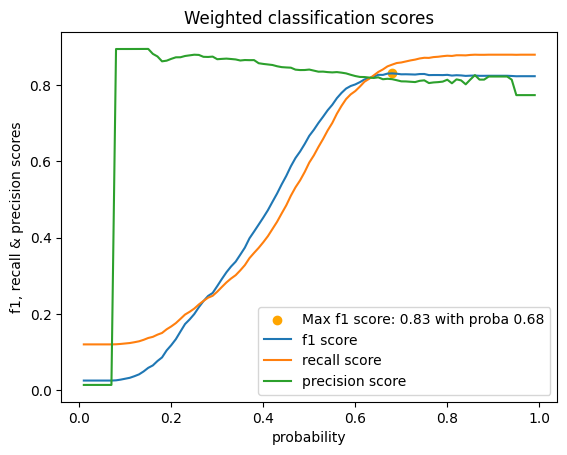

In [117]:
X = df_cleaned_encoded.drop(['target'], axis=1)
y = df_cleaned_encoded['target']

X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X, y, test_size=0.22, random_state=42)

sc = StandardScaler()
X_train_cleaned_transformed = sc.fit_transform(X_train_cleaned)
X_test_cleaned_transformed = sc.transform(X_test_cleaned)

lr_cleaned_data = get_results(LogisticRegression(class_weight='balanced'), X_train_cleaned_transformed, X_test_cleaned_transformed, y_train_cleaned, y_test_cleaned, 'Logistic Regression on cleaned data')

In [119]:
print('Classification report with best treshold')
print(classification_report(lr_cleaned_data.predict_proba(X_test_cleaned_transformed)[:, 1] > 0.68, y_test_cleaned))

Classification report with best treshold
              precision    recall  f1-score   support

       False       0.95      0.89      0.92      3144
        True       0.13      0.28      0.18       196

    accuracy                           0.85      3340
   macro avg       0.54      0.58      0.55      3340
weighted avg       0.90      0.85      0.88      3340



To compare the algorithms, the f measure was chosen. The f measure allows you to compare the completeness and accuracy of finding both classes in one number. Formula:

$$f1 = \frac{2*precision*recall}{precision + recall}$$

- A comparative analysis of the quality of the two algorithms shows that cleaning data from outliers based on the work experience dont has the affect on the quality of the model. This may be due to the insignificance of these featureso at all, or to possible otherfactors. 

- The marketing goal is to find clients of the positive class. The best trade-off for the weighted f-measure between recall and precision is achieved at a threshold of 0.32. Buth these results lead to low precision and recall for the target (positive) class. To achieve the marketing goal, a basic threshold will be maintained.

## Conclusions about the model

Logistic regression was chosen as the basic model for predicting the probability of clients responses. Reasons for choosing logistic regression are:
- quick of learning and prediction;
- possibility of soft classification;
- mathematical interpretability of the probabilities;

The training of models showed that anomalies in the length of service (thay were found during EDA) do not affect the quality of the model. This allows us to leave this data in the training dataset without the need to correct potentially erroneous observations (**however, it is important to clarify the nature of the error**).

In [60]:
#App model code

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

data = pd.read_csv('./datasets/encoded_data.csv')
X = data.drop(['target'], axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23, random_state=42)

sc = StandardScaler()
X_train_transformed = sc.fit_transform(X_train)
X_test_transformed = sc.transform(X_test)

#lr_all_data = get_results(LogisticRegression(class_weight='balanced'), X_train_all_transformed, X_test_all_transformed, y_train_all, y_test_all, 'Logistic Regression on all data')

lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train_transformed, y_train)

LogisticRegression(class_weight='balanced')

In [62]:
lr.predict(X_test_transformed)[1]

0

In [71]:
display(X_test.iloc[1, :]) # X_test_transformed[1]

credit                     9009.0
term                            6
fst_payment                3990.0
age                            59
gender                          0
child_total                     2
dependants                      0
socstatus_work_fl               0
socstatus_pens_fl               1
fl_presence_fl                  0
own_auto                        0
personal_income           35000.0
total_loans_count               1
work_time_in_years            0.0
высшее                       True
среднее                     False
среднее специальное         False
не состоял в браке          False
разведен(а)                 False
состою в браке               True
от 10000 до 20000 руб.      False
от 20000 до 50000 руб.       True
от 5000 до 10000 руб.       False
Name: 4252, dtype: object

In [161]:
import pickle

def get_train_data(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23, random_state=42)
    sc = StandardScaler()
    X_train_transformed = sc.fit_transform(X_train)
    X_test_transformed = sc.transform(X_test)
    
    return X_train_transformed, X_test_transformed, y_train, y_test, X_test

def fit_and_save_linear_model(X_train, y_train, X_test, y_test, path_to_save='./model_files/'):

    model = LogisticRegression(class_weight='balanced')
    model.fit(X_train, y_train)
    
    with open(path_to_save+'linear_model.pickle', 'wb') as f:
        pickle.dump(model, f)

    print(f'Model was saved to {path_to_save}linear_model.pickle')
    np.save(path_to_save+'train_X_data', X_train)
    np.save(path_to_save+'test_X_data', X_test)
    np.save(path_to_save+'train_y_data', y_train)
    np.save(path_to_save+'test_y_data', y_test)


def get_classification_report_to_custom_threshold(model, X_test_data, y_test_data, treshold=0.5):

    predictions_pr = model.predict_proba(X_test_data)[:, 1] 
    predictions_cl = model.predict_proba(X_test_data)[:, 1] > treshold

    #Weighted metrics
    
    recall = recall_score(y_test_data, predictions_cl, average='weighted', zero_division=0)
    precision = precision_score(y_test_data, predictions_cl, average='weighted', zero_division=0)
    f1 = f1_score(y_test_data, predictions_cl, average='weighted', zero_division=0)

    #Classification report

    cl_report = classification_report(y_test_data, predictions_cl)

    weighted_data = pd.DataFrame({'precision' : precision, 'recall' : recall, 'f1': f1}, index=['Weighted metrics'])

    return cl_report, weighted_data

def get_prediction_by_index(model, X_test_data, X_test_original, index=1, treshold=0.5):

    print()
    predictions = model.predict_proba(X_test_data)[:, 1] > treshold
    selected_idx = predictions[index]

    print(f'Прогноз выбранного для данного клиента равен {int(selected_idx)}')
    

def get_shap_values_by_index(model, X_train_data, X_test_data, columns, index=1, treshold=0.5):

    predictions = model.predict_proba(X_test_data)[:, 1] > treshold
    
    f = lambda x: model.predict_proba(x)[:, 1]
    med = np.median(X_train_data, axis=0).reshape((1, X_train_data.shape[1]))
    explainer = shap.Explainer(f, med)
    
    shap_values = explainer(X_test_data)
    
    exp = shap.Explanation(shap_values, 
                  shap_values.base_values, 
                  data=X_train_data, 
                  feature_names=columns)

    shap.waterfall_plot(exp[index])
    

def load_model(path):
    with open(path, 'rb') as f:
        model = pickle.load(f)

    return model
    

In [162]:
data = pd.read_csv('./datasets/encoded_data.csv')
X = data.drop(['target'], axis=1)
y = data['target']


X_train_transformed, X_test_transformed, y_train, y_test, X_test = get_train_data(X, y)
lr = fit_and_save_linear_model(X_train_transformed, y_train, X_test_transformed, y_test)

Model was saved to ./model_files/linear_model.pickle


In [142]:
lr = load_model('linear_model.pickle')

In [143]:
clf_report, weighted_metrics = get_classification_report_to_custom_threshold(lr, X_test_transformed, y_test, 0.32)
print(clf_report)
display(weighted_metrics)

              precision    recall  f1-score   support

           0       0.96      0.16      0.27      3072
           1       0.14      0.96      0.24       430

    accuracy                           0.25      3502
   macro avg       0.55      0.56      0.25      3502
weighted avg       0.86      0.25      0.27      3502



,precision,recall,f1
Weighted metrics,0.862416,0.254997,0.265786


In [146]:
get_prediction_by_index(lr, X_test_transformed, X_test, index=1, treshold=0.5)


Прогноз выбранного для данного клиента равен 0


Permutation explainer: 3503it [00:25, 80.38it/s]                                                                                                                  


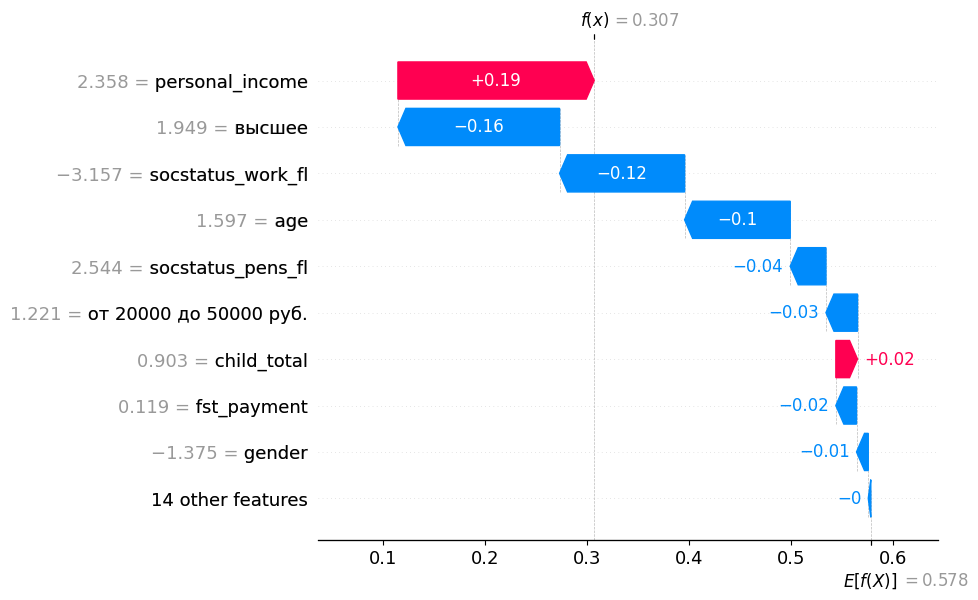

In [147]:
get_shap_values_by_index(lr, X_train_transformed, X_test_transformed, X_test.columns, index=1, treshold=0.5)

## Feature importances

To analyze the importance of features and the impact of data cleaning on importance, let's look at the weights of the models.

In [129]:
def get_weight_data(model, column_names):

    importances_data = pd.DataFrame(model.coef_, columns=column_names).T.reset_index()
    importances_data.columns = ['feature', 'feature_weight']
    importances_data['abs_feature_weight'] = importances_data['feature_weight'].apply(lambda x: np.abs(x))
    
    return importances_data
                                    

In [137]:
get_weight_data(lr_all_data, X_test_all.columns).sort_values(by='abs_feature_weight', ascending=False).head(5)

,feature,feature_weight,abs_feature_weight
13,work_time_in_years,-1.250493,1.250493
11,personal_income,0.342156,0.342156
14,высшее,-0.272204,0.272204
3,age,-0.262809,0.262809
2,fst_payment,-0.229671,0.229671


In [138]:
get_weight_data(lr_cleaned_data, X_test_cleaned.columns).sort_values(by='abs_feature_weight', ascending=False).head(5)

,feature,feature_weight,abs_feature_weight
11,personal_income,0.331613,0.331613
14,Высшее,-0.239500,0.239500
13,work_time_in_years,-0.216337,0.216337
7,socstatus_work_fl,0.210955,0.210955
2,fst_payment,-0.208697,0.208697


It is interesting that in cleaned data the importance of the feature `work_time_in_years` is less than in raw data.

In [63]:
import shap

f = lambda x: lr_all_data.predict_proba(x)[:,1]
med = np.median(X_train_all_transformed, axis=0).reshape((1, X_train_all_transformed.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_test_all_transformed)

exp = shap.Explanation(shap_values, 
                  shap_values.base_values, 
                  data=X_train_all_transformed, 
                  feature_names=X_train_all.columns)

Permutation explainer: 3503it [00:31, 86.21it/s]                                                                                                                  


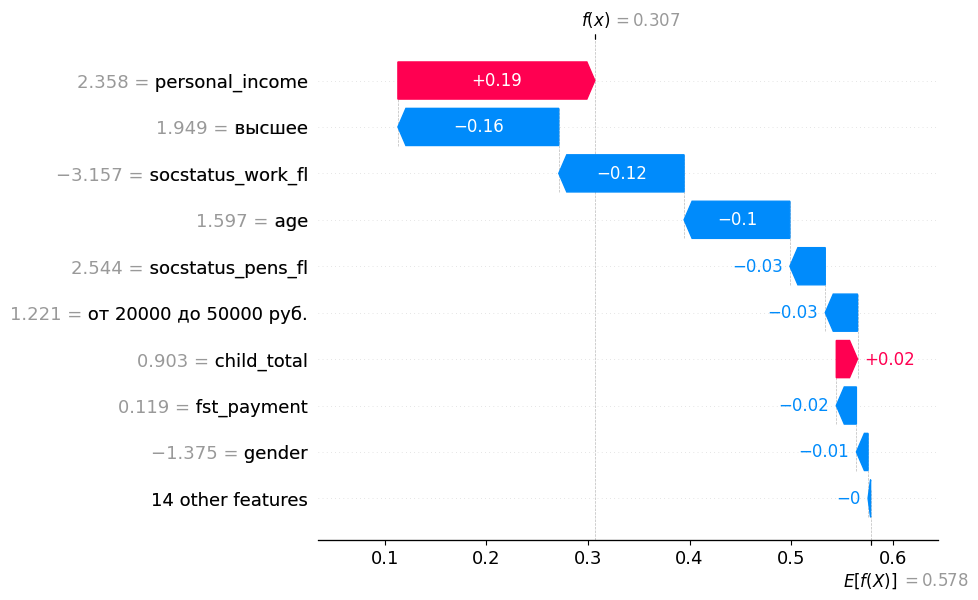

In [65]:
shap.waterfall_plot(exp[1])

In [182]:
exp = shap.Explanation(shap_values, 
                  shap_values.base_values, 
                  data=X_train_all_transformed, 
                  feature_names=X_train_all.columns)

In [195]:
lr_all_data.predict(X_test_all_transformed[7].reshape(1, -1))

array([0])

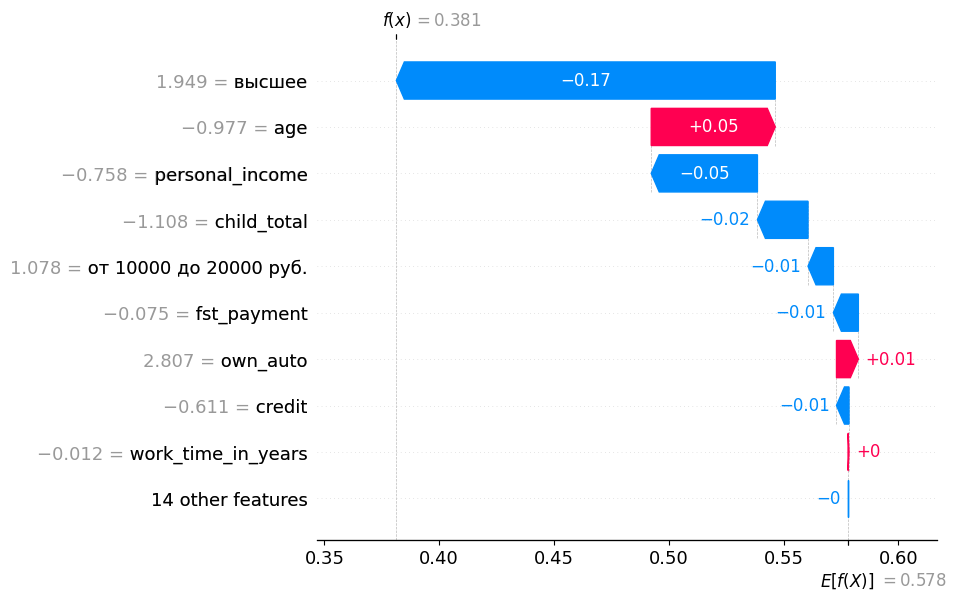

In [197]:
shap.waterfall_plot(exp[7])